In [108]:
import pandas as pd
import numpy as np
import plotly.express as px
import dash
from dash import dcc, html, Input, Output, State
import dash_bootstrap_components as dbc
import random
from typing import List
from dash import dcc

## Генерация данных (логов запросов пользователей) [пример]

In [109]:
campuses = ["Москва", "Нижний Новгород", "Санкт-Петербург", "Пермь"]
education_levels = ["бакалавриат", "магистратура", "специалитет", "аспирантура"]
question_categories = [
    "Деньги", "Учебный процесс", "Практическая подготовка", "ГИА",
    "Траектории обучения", "Английский язык", "Цифровые компетенции",
    "Перемещения / Изменения статусов студентов", "Онлайн-обучение",
    "Цифровые системы", "Обратная связь", "Дополнительное образование",
    "Безопасность", "Наука", "Социальные вопросы", "ВУЦ", "Общежития",
    "ОВЗ", "Внеучебка", "Выпускникам", "Другое"
]

def generate_logs(num_records):
    logs = []

    for _ in range(num_records):
        campus = random.choice(campuses)
        education_level = random.choice(education_levels)
        question_category = random.choice(question_categories)
        response_time = round(random.uniform(1.0, 10.0), 4)

        user_filters = f'{campus}, {education_level}'
        question_filters = ', '.join(random.sample(question_categories, k=random.randint(1, 3)))

        if random.random() < 0.7:
            chat_history = None
        else:
            chat_history = {
                "old_contexts": "Пример текста контекста",
                "old_questions": "Когда пересдача?",
                "old_answers": "Пересдача пройдет в сентябре."
            }

        log = {
            'campus': campus,
            'education_level': education_level,
            'question_category': question_category,
            'response_time': response_time,
            'user_filters': user_filters,
            'question_filters': question_filters,
            'chat_history': chat_history
        }
        logs.append(log)
    return pd.DataFrame(logs)

In [110]:
df_logs = generate_logs(1000)

In [111]:
df_logs.head(3)

,campus,education_level,question_category,response_time,user_filters,question_filters,chat_history
0,Нижний Новгород,аспирантура,Деньги,4.7555,"Нижний Новгород, аспирантура","Цифровые системы, Онлайн-обучение",None
1,Нижний Новгород,аспирантура,Цифровые компетенции,6.0218,"Нижний Новгород, аспирантура",Безопасность,None
2,Москва,магистратура,ВУЦ,9.3402,"Москва, магистратура","Практическая подготовка, Цифровые компетенции,...","{'old_contexts': 'Пример текста контекста', 'o..."


---

## Предположим мы придумали способ рассчета CDI

$$
CDI = (1 - accuracy) · persuasiveness
$$

Создаем новый столбец в датафрейме с найденными значениями

In [112]:
def calculate_cdi(chat_history):
    if not chat_history:
        factual_accuracy = random.uniform(0.8, 1.0)
    else:
        factual_accuracy = random.uniform(0.0, 0.5)

    if not chat_history:
        persuasiveness = random.uniform(0.0, 0.5)
    else:
        persuasiveness = random.uniform(0.5, 1.0)

    cdi = (1 - factual_accuracy) * persuasiveness
    return cdi

In [113]:
df_logs['cdi'] = df_logs.chat_history.apply(calculate_cdi)

In [114]:
df_logs.head(3)

,campus,education_level,question_category,response_time,user_filters,question_filters,chat_history,cdi
0,Нижний Новгород,аспирантура,Деньги,4.7555,"Нижний Новгород, аспирантура","Цифровые системы, Онлайн-обучение",None,0.006082
1,Нижний Новгород,аспирантура,Цифровые компетенции,6.0218,"Нижний Новгород, аспирантура",Безопасность,None,0.019391
2,Москва,магистратура,ВУЦ,9.3402,"Москва, магистратура","Практическая подготовка, Цифровые компетенции,...","{'old_contexts': 'Пример текста контекста', 'o...",0.566439


---

In [115]:
metrics_data = {
    "context_recall": 0.6500,
    "context_precision": 0.7200,
    "answer_correctness_literal": 0.5800,
    "answer_correctness_neural": 0.6800,
    'average_cdi': df_logs['cdi'].mean()
}

df_metrics = pd.DataFrame(list(metrics_data.items()), columns=['Metric', 'Value'])

In [116]:
df_metrics.iloc[0]

Metric    context_recall
Value               0.65
Name: 0, dtype: object

In [117]:
df_metrics

,Metric,Value
0,context_recall,0.650000
1,context_precision,0.720000
2,answer_correctness_literal,0.580000
3,answer_correctness_neural,0.680000
4,average_cdi,0.181834


---

## Дашборд

#### Графики

Распределение пользователей по кампусам

In [118]:
coolors = ['#D972FF', '#8447FF', '#8CFFDA', '#FFFFE8']

In [119]:
campus_distribution = df_logs.campus.value_counts().reset_index()

In [120]:
campus_distribution

,campus,count
0,Нижний Новгород,302
1,Москва,270
2,Пермь,224
3,Санкт-Петербург,204


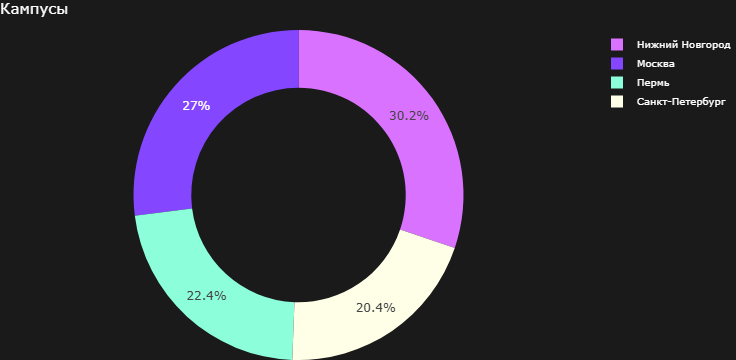

In [121]:
fig_campus = px.pie(
    campus_distribution,
    names='campus',
    values='count',
    title='Кампусы',
    labels={'campus': 'Кампус', 'count': 'Количество'},
    color_discrete_sequence=coolors,
    hover_name='campus',
    hole=0.65
)

fig_campus.update_layout(
    title_font=dict(size=15, color='white'),
    paper_bgcolor='#1a1a1a',
    title_x=0,
    title_y=0.99,
    margin=dict(l=0, r=0, t=30, b=0),
    ##height=270,
    ##width=300,
    legend=dict(  # Настройка легенды
        font=dict(size=10, color='white'),  # Уменьшаем размер шрифта легенды
        y=1,               # Позиция по вертикали
        x=1,
        bgcolor="rgba(0,0,0,0)",  # Прозрачный фон легенды
        bordercolor="rgba(0,0,0,0)",  # Без границы
        itemwidth=30  
    ),
    clickmode='event+select'
)

fig_campus.update_traces(
    hovertemplate='<b>%{label}</b><br>Количество: %{value}<extra></extra>'
)

fig_campus.show(config={'displayModeBar': False})

Разбивка по уровням образования

In [122]:
education_distribution = df_logs.education_level.value_counts().reset_index()

In [123]:
education_distribution

,education_level,count
0,магистратура,277
1,специалитет,252
2,бакалавриат,238
3,аспирантура,233


In [124]:
fig_education = px.pie(
    education_distribution,
    names='education_level',
    values='count',
    labels={'education_level': 'Уровень образования', 'count': 'Количество'},
    color_discrete_sequence=coolors,
    title='Образование',
    hover_name='education_level',
    hole=0.65
)

fig_education.update_layout(
    title_font=dict(size=15, color='white'),
    paper_bgcolor="#1a1a1a",
    title_x=0.01,
    title_y=0.99,
    margin=dict(l=0, r=0, t=30, b=0),
    ##height=270,
    ##width=300,
    legend=dict(  # Настройка легенды
        font=dict(size=10, color='white'),  # Уменьшаем размер шрифта легенды
        y=1,               # Позиция по вертикали
        x=1,
        bgcolor="rgba(0,0,0,0)",  # Прозрачный фон легенды
        bordercolor="rgba(0,0,0,0)",  # Без границы
        itemwidth=45 
    ),
)

fig_education.update_traces(
    hovertemplate='<b>%{label}</b><br>Количество: %{value}<extra></extra>'
)

fig_education.show(config={'displayModeBar': False})

Категории вопросов

In [125]:
category_distribution = df_logs.question_category.value_counts().reset_index().sort_values('count')

In [126]:
category_distribution

,question_category,count
20,Общежития,37
19,ОВЗ,38
18,Английский язык,40
17,Цифровые системы,41
16,Траектории обучения,42
15,ВУЦ,42
14,Дополнительное образование,42
13,Внеучебка,43
12,Другое,44
11,ГИА,46


In [127]:
fig_categories = px.bar(
    category_distribution,
    y='question_category',
    x='count',
    title='Категории вопросов',
    color_discrete_sequence=['#8CFFDA'],
    labels={'question_category': '', 'count': 'Количество'},
    hover_name='question_category'
)

fig_categories.update_layout(
    title_font=dict(size=15, color='white'),
    font=dict(color='white'),
    plot_bgcolor='#303030',
    paper_bgcolor='#303030',
    title_x=0,
    title_y=0.99,
    margin=dict(l=0, r=0, t=30, b=0),
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
    ),
    yaxis=dict(
        side='left',
        showticklabels=True,
    ),
    #height=650,
    #width=1450
)

fig_categories.update_traces(
    width=0.7,
    hovertemplate='<b>%{label}</b><br>Количество: %{value}<extra></extra>'
)

fig_categories.show(config={'displayModeBar': False})

Частота пустых и непустых параметров chat_history

In [128]:
chat_history_empty = df_logs['chat_history'].apply(lambda x: 'Пустой' if x == None else 'Непустой').value_counts().reset_index()

In [129]:
chat_history_empty

,chat_history,count
0,Пустой,709
1,Непустой,291


In [130]:
fig_chat_history_empty = px.pie(
    chat_history_empty,
    names='chat_history',
    values='count',
    labels={'chat_history': 'Значение параметра', 'count': 'Количество'},
    color_discrete_sequence=coolors,
    title='Частота пустых и непустых параметров chat_history',
    hover_name='chat_history',
    hole=0.6,
)

fig_chat_history_empty.update_layout(
    title_font=dict(size=15),
    paper_bgcolor='white',
    title_x=0,
    title_y=1,
    margin=dict(l=0, r=0, t=30, b=0)
)

fig_chat_history_empty.update_traces(
    hovertemplate='<b>%{label}</b><br>Количество: %{value}<extra></extra>'
)

fig_chat_history_empty.show(config={'displayModeBar': False})

---

In [131]:
polar_fig = px.line_polar(
    category_distribution,
    r='count',
    theta='question_category',
    line_close=True,
    title='Вопросы',
    color_discrete_sequence=['#8CFFDA']
)
polar_fig.update_traces(fill='toself', opacity=0.4)
polar_fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            #range=[0, 70],
            gridcolor="#898989",  # Цвет линий сетки (радиальная ось)
            tickfont=dict(color="#898989")  # Цвет меток на радиальной оси
        ),
        angularaxis=dict(
            gridcolor="#898989",  # Цвет линий сетки (угловая ось)
            tickfont=dict(color="#898989")  # Цвет меток на угловой оси
        ),
        bgcolor="#1a1a1a"  # Цвет фона полярной диаграммы
    ),
    showlegend=False,
    font=dict(color="white"),
    title_font=dict(size=15, color='white'),
    title_x=0,
    title_y=0.99,
    ##height=565,
    ##width=740,
    polar_bgcolor="#1a1a1a",
    paper_bgcolor='#1a1a1a',
    margin=dict(l=30, r=30, t=30, b=30)
)
polar_fig.show(config={'displayModeBar': False})

---

Метрики рандомные

In [132]:
pr_df = pd.DataFrame({
    'Metric': [
        'Среднее время обработки (сек)', 
        'Частота пустых chat_history (%)', 
        'Частота непустых chat_history (%)'
    ],
    'Value': [
        round(np.random.uniform(2, 5), 2),  # Среднее время 2-5 сек
        65.3,           # 50-90% пустых chat_history
        100 - 65.3          # 10-50% непустых chat_history
    ]
})

In [133]:
pr_df

,Metric,Value
0,Среднее время обработки (сек),2.42
1,Частота пустых chat_history (%),65.30
2,Частота непустых chat_history (%),34.70


In [134]:
average_processing_time = df_metrics.iloc[0]['Value']

In [135]:
average_processing_time

0.65

In [136]:
metric1_card = dbc.Col(
    html.Div(
        [
            html.H6('Context recall', className="card-title", style={'color': '#898989'}),
            html.H1(f"{df_metrics.loc[0, 'Value']:.2f}", className="card-text")
        ],
        style={
            'background-color': 'black',
            'color': 'white',
            'padding': '15px',  # Добавляем отступы для имитации padding карточки
            'border': 'none',  # Убираем обводку
            'border-radius': '0px',  # Убираем скругление углов
            'box-shadow': 'none',  # Убираем тень
            'text-align': 'left'  # Центрируем текст
        },
        className='no-border-card'
    ),
    width=2
)

metric2_card = dbc.Col(
    html.Div(
        [
            html.H6('Context precision', className="card-title", style={'color': '#898989'}),
            html.H1(f"{df_metrics.loc[1, 'Value']:.2f}", className="card-text")
        ],
        style={
            'background-color': 'black',
            'color': 'white',
            'padding': '15px',  # Добавляем отступы для имитации padding карточки
            'border': 'none',  # Убираем обводку
            'border-radius': '0px',  # Убираем скругление углов
            'box-shadow': 'none',  # Убираем тень
            'text-align': 'left'  # Центрируем текст
        }
    ),
    width=2
)

metric3_card = dbc.Col(
    html.Div(
        [
            html.H6('Answer correctness literal', className="card-title", style={'color': '#898989'}),
            html.H1(f"{df_metrics.loc[2, 'Value']:.2f}", className="card-text")
        ],
        style={
            'background-color': 'black',
            'color': 'white',
            'padding': '15px',  # Добавляем отступы для имитации padding карточки
            'border': 'none',  # Убираем обводку
            'border-radius': '0px',  # Убираем скругление углов
            'box-shadow': 'none',  # Убираем тень
            'text-align': 'left'  # Центрируем текст
        }
    ),
    width=2
)

metric4_card = dbc.Col(
    html.Div(
        [
            html.H6('Answer correctness neural', className="card-title", style={'color': '#898989'}),
            html.H1(f"{df_metrics.loc[3, 'Value']:.2f}", className="card-text")
        ],
        style={
            'background-color': 'black',
            'color': 'white',
            'padding': '15px',  # Добавляем отступы для имитации padding карточки
            'border': 'none',  # Убираем обводку
            'border-radius': '0px',  # Убираем скругление углов
            'box-shadow': 'none',  # Убираем тень
            'text-align': 'left'  # Центрируем текст
        }
    ),
    width=2
)

metric5_card = dbc.Col(
    html.Div(
        [
            html.H6('Average CDI', className="card-title", style={'color': '#898989'}),
            html.H1(f"{df_metrics.loc[4, 'Value']:.2f}", className="card-text")
        ],
        style={
            'background-color': 'black',
            'color': 'white',
            'padding': '15px',  # Добавляем отступы для имитации padding карточки
            'border': 'none',  # Убираем обводку
            'border-radius': '0px',  # Убираем скругление углов
            'box-shadow': 'none',  # Убираем тень
            'text-align': 'left'  # Центрируем текст
        }
    ),
    width=2
)

av_t = 3.29

metric6_card = dbc.Col(
    html.Div(
        [
            html.H6('Average Time', className="card-title", style={'color': '#898989'}),
            html.H1(f'{av_t}c', className="card-text")
        ],
        style={
            'background-color': 'black',
            'color': 'white',
            'padding': '15px',  # Добавляем отступы для имитации padding карточки
            'border': 'none',  # Убираем обводку
            'border-radius': '0px',  # Убираем скругление углов
            'box-shadow': 'none',  # Убираем тень
            'text-align': 'left'  # Центрируем текст
        }
    ),
    width=2
)

In [137]:
row_1 = html.Div(
    [
        html.Div(
            [
                dcc.Graph(
                    id='campus-pie',
                    figure=fig_campus,
                    config={'displayModeBar': False},
                    responsive=True,
                    style={'height': '100%', 'width': '100%'}
                )
            ],
            style={
                'padding': '2vh',
                'backgroundColor': '#1a1a1a',
                'borderRadius': '30px',
                'height': '100%',          # Занимаем всю высоту родителя
                'width': '48%',            # Процентная ширина
                'marginRight': '2vh',
                'boxSizing': 'border-box' # Ключевое исправление
            }
        ),
        html.Div(
            [
                dcc.Graph(
                    id='education-pie',
                    figure=fig_education,
                    config={'displayModeBar': False},
                    responsive=True,
                    style={'height': '100%', 'width': '100%'}
                )
            ],
            style={
                'padding': '2vh',
                'backgroundColor': '#1a1a1a',
                'borderRadius': '30px',
                'height': '100%',
                'width': '48%',
                'boxSizing': 'border-box'
            }
        )
    ],
    style={
        'display': 'flex',
        'height': '40vh',         # Фиксируем высоту всей строки
        'width': '100%',
        'gap': '0vh',
        'marginBottom': '2vh',
        'marginRight': '2vh'
    }
)

In [138]:
average_processing_time = df_metrics.iloc[0]['Value']

row_2 = html.Div(
    [
        # Невидимая кнопка-триггер
        dbc.Button(
            id='open-row2',
            className="w-100 h-100",
            style={
                'position': 'absolute',
                'top': '0',
                'left': '0',
                'width': '100%',
                'height': '100%',
                'opacity': '0',
                'zIndex': '1',
                'cursor': 'pointer'
            }
        ),
        # Ваш контент
        html.H1(
            f"Частота повторяющихся вопросов: 56.7%",
            style={
                'color': 'white',
                'fontSize': '24px',
                'margin': '0',
                'position': 'relative',
                'zIndex': '0'
            }
        ),
        # Модальное окно
        dbc.Modal(
            [
                dbc.ModalHeader("Детали метрики", close_button=True),
                dbc.ModalBody("Содержание модального окна...")
            ],
            id="modal-row2",
            is_open=False,
            size="lg"
        )
    ],
    style={
        'position': 'relative',
        'padding': '2.7vh',
        'backgroundColor': '#8447FF',
        'borderRadius': '30px',
        'height': '10vh',
        'width': '47vw',
        'marginBottom': '2vh',
        'display': 'flex',
        'alignItems': 'center',
        'justifyContent': 'center'
    }
)

In [139]:
empty_chat_history_freq = pr_df.iloc[1]['Value']  # Частота пустых chat_history (%)
non_empty_chat_history_freq = pr_df.iloc[2]['Value']

row_3 = html.Div(
    [
        # Первый div
        html.Div(
            [
                html.H4("Пустой chat history"),
                html.H1(f"{empty_chat_history_freq:.1f}%")
            ],
            style={
                'color': 'black',
                'padding': '20px',
                'background': 'white',  # Белый фон для контраста
                'border-radius': '30px',
                'height': '26vh',
                'width': '23vw',  # Уменьшаем ширину для компенсации отступов
                'margin-right': '2vh'  # Добавляем отступ справа
            }
        ),
        # Второй div
        html.Div(
            [
                html.H4("Непустой chat history"),
                html.H1(f"{non_empty_chat_history_freq:.1f}%")
            ],
            style={
                'color': 'black',
                'padding': '20px',
                'background': 'white',  # Белый фон для контраста
                'border-radius': '30px',
                'height': '26vh',
                'width': '23vw'  # Уменьшаем ширину для компенсации отступов
            }
        )
    ],
    style={
        'display': 'flex',  # Используем Flexbox для размещения элементов в одну строку
        'gap': '0vw',
        'margin-right': '2vh'
    }
)

In [140]:
right_side = html.Div(
    [
        # Оберточный контейнер для графика и кнопки
        html.Div(
            [
                dcc.Graph(
                    figure=polar_fig,
                    config={'displayModeBar': False},
                    responsive=True,
                    style={
                        'height': '100%',  # Добавляем явное наследование
                        'width': '100%',
                        'min-height': '400px'  # Защита от слишком сильного сжатия
                    }
                ),
                dbc.Button(
                    id='open-polar',
                    className="position-absolute",
                    style={
                        'background-color': 'black',
                        'border': 'none',
                        'top': '15px',  # Фиксируем позицию кнопки
                        'right': '15px',
                        'z-index': '1000'  # Поднимаем над графиком
                    }
                ),
            ],
            style={
                'position': 'relative',  # Для абсолютного позиционирования кнопки
                'height': '100%',       # Занимаем всю высоту родителя
                'width': '100%'
            }
        ),
        
        dbc.Modal(
            [
                dbc.ModalHeader(
                    dbc.ModalTitle('Распределение вопросов'),
                    close_button=True
                ),
                dbc.ModalBody(
                    dcc.Graph(
                        figure=fig_categories,
                        config={'displayModeBar': False},
                        responsive=True,
                        style={'height': '80vh'}  # Фиксируем высоту в модалке
                    )
                )
            ],
            id='modal-polar',
            is_open=False,
            fullscreen=True,
        )
    ],
    style={
        'padding': '2vh',
        'backgroundColor': '#1a1a1a',
        'borderRadius': '30px',
        'height': '80vh',
        'width': '51vw',
        'display': 'flex',          # Добавляем flex-контейнер
        'flexDirection': 'column',  # Вертикальное выравнивание
        'boxSizing': 'border-box'   # Ключевое исправление
    }
)

---

#### Программа

In [150]:
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])

## для полярного графика
@app.callback(
    Output('modal-polar', 'is_open'),
    [Input('open-polar', 'n_clicks')],
    [State('modal-polar', 'is_open')]
)

@app.callback(
    Output('modal-row2', 'is_open'),
    Input('open-row2', 'n_clicks'),
    State('modal-row2', 'is_open')
)

def toggle_modal(n, is_open):
    if n:
        return not is_open
    return is_open

def toggle_modal_polar(n_clicks, is_open):
    if n_clicks:
        return not is_open
    return is_open

app.layout = dbc.Container(
    [
        # Блок с метриками
        html.Div(
            [
                metric1_card,
                metric2_card,
                metric3_card,
                metric4_card,
                metric5_card,
                metric6_card
            ],
            style={
                'display': 'flex',
                'justify-content': 'center',
                'padding-bottom': '0px'
            }
        ),

        html.Div(
            [
                html.Div(
                    [
                        row_1,
                        row_2,
                        row_3 
                    ]
                ),
        
                right_side
            ],
            style={
                'display': 'flex', 
            }
        )
        
        
        
        
    ],
    fluid=True,
    style={
        'background-color': 'black',
        'min-height': '100vh',
    }
)

if __name__ == "__main__":
    app.run_server(debug=False, port=8050)